# Visualisation of electric current spectra (Gabor transform) obtained by *cntr* code

### Warning: material-specific code, use only for La<sub>2</sub>CuO<sub>4</sub>, implicit energy and time renormalization 0.43, based on compound bandwidth is used. Only *x* field projection is read from the current file, i.e. the value of current is multiplied by sqrt(2) for the [110] polarization


#### File name: **gt.py** 
#### Input:
- Electric current versus time **j.out**, output of *cntr* code
  - Energy/time renormalization is **0.43** (hard-coded, material-specific for La<sub>2</sub>CuO<sub>4</sub> due to material bandwidth)
- Electric field profile **Pulse_xy.dat**, output of *cntr* code
  - Only *x* field projection is read from the current file, i.e. the value of field strength is multiplied by sqrt(2) for the [110] polarization
  
#### Output:
 - The **Jxy.png** file. 
  - The upper panel shows electric field profile and electric current
  - The middle panel shows electric current spectra vs time
  - The lower panel shows spectra of electric field (averaged) and electric current (averaged, and at two certain times)
 - **x.dat**, **y.dat** files: values of time and current used as an input for **FFT** 
 - **xf.dat**, **yf.dat** files: values of frequency and current of the **FFT** result
### Code

#### Loading libraries:

In [1]:
import numpy as np
from numpy import arange, cos, sin
import os, sys
import re
import shutil
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pylab
from scipy.fftpack import fft, ifft
import scipy
from pylab import *
import sys
import math

from numpy import sin, linspace, pi
from pylab import plot, show, title, xlabel, ylabel, subplot
from scipy import fft, arange
#from scipy.fftpack import fft

#### Setting calculation parameters:

In [2]:
#PARAMETERS of DMFT calculation:
h = 0.01
# time step as in Martin's code
Scaling=0.43
0.43

#PARAMETERS for Fourier transform:
MaxFreq2D=6
# Max frequency for spectral 2D plots in eV
PrefactorJ=80
PrefactorJF=164

#PARAMETERS for Gabor transform:
wPlotMax=16
tick_spacingW = 2.0
# tick step in W (eV)
tick_spacingT = 2
# tick step in t (fs) 
# wPlotMax, tick_spacing in eV for Gabor 3D plot
WGinp=2.4
# Width of Gabor Gaussian in fs

#### Reading input files:

In [3]:
f = open('j.out', "r")

t_1 = np.array([])
Jxy = np.array([])
Axy = np.array([])

nl=0
for line in f:
	 nl=nl+1
	 val1=(line.split()[0])
	 t_1=np.append(t_1,float(val1))
	 val2=(line.split()[2])
	 Jxy=np.append(Jxy,float(val2))
f.close
#print(Jxy)
f = open('Pulse_xy.dat', "r")
next(f)
next(f)


for line in f:
	val1=(line.split()[0])
	val2=(line.split()[1])
#	val3=(line.split()[2])
	Axy=np.append(Axy,float(val2))
#	Axy=np.append(Axy,np.sqrt(float(val2)**2+float(val3**2)))
     
f.close

<function TextIOWrapper.close()>

#### Performing FFT:

In [4]:
# Number of sample points:

N = nl
print(nl)

#T = 1/627.29
x=t_1*h*0.66/Scaling
y = Jxy*np.sqrt(2)
yA= Axy*np.sqrt(2)
#*np.sqrt(2)



#y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
yfA = fft(yA)
#xf =  np.linspace(0.0, N/2, N)
#Given sampling rate FSample and transform blocksize N, you can calculate 
#the frequency resolution deltaF, sampling interval deltaT, 
#and total capture time capT using the relationships:
#
#deltaT = 1/FSample = capT/N
#deltaF = 1/capT = FSample/N
#Keep in mind also that the FFT returns value from 0 to FSample, 
#or equivalently -FSample/2 to FSample/2. 
#In your plot, you're already dropping the -FSample/2 to 0 part
#
# From StackOverflow
FreqStep=4.13/(N*h*0.66/Scaling)
wmax=0.5*N*FreqStep
xf =  np.linspace(0.0, wmax, N//2)

#print(x[N-1])
#print(wmax)
#print(N//2)

import matplotlib.pyplot as plt
#plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

np.savetxt('xfj.dat',xf)
np.savetxt('yfj.dat',np.abs(yf))
np.savetxt('x.dat',x)
np.savetxt('y.dat',y)

1371


#### Performing Gabor transform as FFT of Gaussian-enveloped timeslices:

In [5]:
#Ns = np.int(x[N-1])

Ns=np.int(2*N*h*0.66/(WGinp*Scaling))
# number of Gabor slices, one slice is (total time / W ) * 2 fs
WG=2*x[N-1]/Ns
# new Gabor Widtn, in order to maintain integer number of slices
GaborSliceWidth=WG/2

gt = empty([N,Ns])
#gt[:]=yf

#print((Ns+1)*WG/2.0)
#print(x[N-1])

# i below is already in fs, and j not

yG = empty([N])

for i in range(Ns):
    for j in range(N):
        yG[j]=y[j]*exp(-((j*h*0.66/Scaling)-i*GaborSliceWidth)**2/(WG**2))
      # yG[j]=yA[j]*exp(-((j*h*0.66)-i)**2/(WG**2))
      # yG=y
    yfG=fft(yG)
    gt[:,i]= np.abs(yfG) 

#### Making three-panel plot:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
No handles with labels found to put in legend.


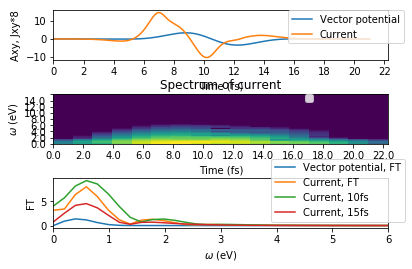

In [9]:
plt.subplots_adjust(hspace=0.7)
subplot(3,1,1)
#plt.xlim(0,x[N-1])
plt.xlim(0,(Ns+1)*WG/2.0)
plt.xticks(np.arange(0, 1+np.int((Ns+1)*WG/2.0), step=2))
plot(x,yA, label="Vector potential")
plot(x,y*PrefactorJ, label="Current")
xlabel('Time (fs)')
ylabel('Axy, Jxy*8')
plt.legend(bbox_to_anchor=(0.70, 1), loc='upper left', borderaxespad=0)


subplot(3,1,3)
plt.xlim(0,MaxFreq2D)
plot(xf, 2.0/N * np.abs(yfA[0:N//2]), label="Vector potential, FT")
plot(xf, PrefactorJF*2.0/N * np.abs(yf[0:N//2]), label="Current, FT")
plot(xf, 2*PrefactorJF*2.0/N * np.abs(gt[0:N//2, 7]), label="Current, 10fs")
plot(xf, 4*PrefactorJF*2.0/N * np.abs(gt[0:N//2, 11]), label="Current, 15fs")
plt.legend(bbox_to_anchor=(0.65, 1.4), loc='upper left', borderaxespad=0)
xlabel(r'$\omega$ (eV)')
ylabel('FT')


wPlotMaxFreqSteps=wPlotMax/FreqStep
subplot(3,1,2)
plt.xlim(0,Ns)
plt.ylim(0,wPlotMaxFreqSteps)
plt.title('Spectrum of current')
xlabel('Time (fs)')
ylabel(r'$\omega$ (eV)')
plt.yticks( np.linspace(0.0, wPlotMax/FreqStep, (wPlotMax/tick_spacingW+1)), np.arange(0, wPlotMax, tick_spacingW))
plt.xticks( np.linspace(0.0, ((Ns-1)*(1+np.trunc(x[N-1]/tick_spacingT))*tick_spacingT/x[N-1]), (2+np.trunc(x[N-1]/tick_spacingT))), np.arange(0,(2+np.trunc(x[N-1])),tick_spacingT))
#colors.LogNorm()
plt.pcolormesh(gt,norm=LogNorm(vmin=0.003, vmax=20))
plt.legend(bbox_to_anchor=(0.75, 1), loc='upper left', borderaxespad=0)
#plt.colorbar(label="Current, GT")

#plt.savefig("Jxy.png")
plt.show()